@2025.6.5去年底雅婷给的包含事件相关分析的代码

In [2]:
import numpy as np 
import scipy as sp
import sklearn as sk
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import gaussian_kde
from sklearn.metrics import calinski_harabasz_score
from matplotlib.gridspec import GridSpecFromSubplotSpec
import time, os

In [2]:
# LOAD DATA
name = '/movement_initial' # name of simulation to plot
figdir = 'figs/single_trial_all_speed_pca_de novo'+name
teston = 'test_set5' # which data to plot
save = True # whether to save the figures

params = np.load('interception.npy',allow_pickle=True)
dinit = np.load('interception-test-dataset2.npy',allow_pickle=True).item()[teston]

In [139]:
print(dinit.keys())

dict_keys(['test_target', 'trial_id', 'activity1b', 'activity1', 'activity2', 'output', 'dir_id', 'object_traj'])


In [95]:
240*0.68

163.20000000000002

In [3]:
# UTILS

def cluster(matrix,link,aff):
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage=link,metric=aff)
    model = model.fit(matrix)
    idx=[]
    R=plot_dendrogram(model, no_plot=True)
    idx=np.array(R['leaves'])
    return idx

def GetBound(matrix,link,aff,threshold):
    Z = linkage(matrix, link,aff)
    clusters = fcluster(Z, t=threshold, criterion='distance')
    boundaries_y=np.zeros(len(set(clusters)))
    for i in range(len(set(clusters))):
        boundaries_y[i]=np.sum(clusters==i+1)
    return boundaries_y

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = model.labels_.shape[0]
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    R=dendrogram(linkage_matrix,**kwargs)
    return R

def EvaluateCluster(matrix,bound,idx):
    kde=np.zeros(len(bound)-1)
    for i in range(len(bound)-1):
        if i==0:
            cluster=matrix[idx[bound[i]:bound[i+1]],:]
            kind=[f'cluster{i+1}']*cluster.shape[0]
            continue
        cluster_i=matrix[idx[bound[i]:bound[i+1]],:]
        cluster=np.concatenate([cluster,cluster_i])
        
        kind_i=[f'cluster{i+1}']*cluster_i.shape[0]
        kind=kind+kind_i
        
    score=calinski_harabasz_score(cluster, kind)
    return score

speed_cond=[-240,-120,0,120,240]
speed_cond=np.array(speed_cond)
cmap = ['gray','pink','bwr','summer','autumn','cool','winter','hot'] # color definition
cmp2 = [plt.cm.magma(i) for i in np.linspace(0.1,0.9,8)]
def color(tid):
    for j in range(5):
        c = np.lenth(tid==speed_cond[j])
    return c

def calc_psth(dat,tid,speed,tid0):
    act0 = dat[:,100:] # 下标1对应400个时间点，其中282-60到282+60对应手臂运动的time window (282 corresponds to GO signal)
    psth = []
    for jj in range(8):
        idx = np.where([(tid0==jj)&(tid==speed)])#
        psth.append(np.nanmean(act0[idx[1]],axis=0))#沿0轴计算算数平均值，且跳过其中的nan值
    psth = np.array(psth)
    return psth

def calc_npsth(dat,tid,speed,tid0,bound):
    act0 = dat[:,bound[0]:bound[1]] # 下标1对应400个时间点，其中282-60到282+60对应手臂运动的time window (282 corresponds to GO signal)
    psth = []
    for jj in range(8):
        idx = np.where([(tid0==jj)&(tid==speed)])#
        psth.append(np.nanmean(act0[idx[1]],axis=0))#沿0轴计算算数平均值，且跳过其中的nan值
    psth = np.array(psth)
    return psth

def PlotActivityHeatmap(matrix,area,speed,dir,vmin,vmax,bound,idx):
    ax_list=np.linspace(0,399,21,dtype=int)
    ax_list=list(ax_list)
    speed_num=len(speed)
    dir_num=len(dir)
    fig=plt.figure(figsize=(20, 20))
    for i in range(speed_num):#speed cond
        axs=plt.subplot(1,speed_num,i+1)
        axs.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
        axs.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
        axs.set_xticks([])  # 移除x轴的刻度标记
        axs.set_yticks([])
        axs.spines['bottom'].set_visible(False)
        axs.spines['top'].set_visible(False)
        axs.spines['right'].set_visible(False)
        axs.spines['left'].set_visible(False)
        axs.text(0.5, 1.02, f'speed={speed[i]}', fontsize=14,horizontalalignment='center',\
                  verticalalignment='center', transform=plt.gca().transAxes)
        # axs.set_title(f'speed={speed[i]}',position=(0.5,1.02), verticalalignment='bottom')
        subplotspec = axs.get_subplotspec()
        gs00 = GridSpecFromSubplotSpec(dir_num,1, subplot_spec=subplotspec, wspace=0.1, hspace=0.1)
        for j in range(dir_num):#dir cond 
            ax1 = fig.add_subplot(gs00[j,0]) 
            ax1=sns.heatmap(matrix[i,j].T,ax=ax1,cmap='jet',cbar=False)
            ax1.text(0.5, 1.01,f'dir={dir[j]*45}°', fontsize=13,horizontalalignment='center',\
                  verticalalignment='bottom', transform=plt.gca().transAxes)
            ax1.set_yticks(ax_list,idx[ax_list])
            ax1.set_xticks([0,67],['TO','MO'],rotation=0)
            ax1.set_ylabel(f'{area}_neuron')
            for k in range(len(bound)):
                ax1.axhline(bound[k],linestyle='--',color='white')
            ax1.axvline(x=67, linestyle='--', color='w', linewidth=1.5)
            ax1.invert_yaxis()    
            if (i==speed_num-1) and (j==dir_num-1):
                cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
                fig.colorbar(ax1.collections[0], cax=cbar_ax)

        ax1.set_xlabel('time')
        
    return fig  

In [4]:
# EXTRACT NETWORK ACTIVITY
up = dinit['activity1b']
pmd = dinit['activity1']
m1 = dinit['activity2']
tid = dinit['trial_id']
target = dinit['test_target']
object_traj = dinit['object_traj']
nout = dinit['output']
tid0 = dinit['dir_id']
# datname = './data/traj_data'
# data = np.load(datname+'.npz')
#hand_traj = data['hand_traj']
pi = np.pi

# normalize m1 activity
m1_nor_1=np.zeros_like(m1)
m1_nor_2=np.zeros_like(m1)
for i in range(np.shape(m1)[-1]):
    m1_factor = (np.max(m1[:,:,i])-np.min(m1[:,:,i]))+5
    m1_nor_1[:,:,i] = m1[:,:,i]/m1_factor 
m1_mean = np.nanmean(m1_nor_1,axis=0)
m1_nor_2 = m1_nor_1-m1_mean

# normalize pmd activity
pmd_nor_1=np.zeros_like(pmd)
pmd_nor_2=np.zeros_like(pmd)
for i in range(np.shape(pmd)[-1]):
    pmd_factor = (np.max(pmd[:,:,i])-np.min(pmd[:,:,i]))+5
    pmd_nor_1[:,:,i] = pmd[:,:,i]/pmd_factor 
pmd_mean = np.nanmean(pmd_nor_1,axis=0)
pmd_nor_2 = pmd_nor_1-pmd_mean

# normalize up activity
up_nor_1=np.zeros_like(up)
up_nor_2=np.zeros_like(up)
for i in range(np.shape(up)[-1]):
    up_factor = (np.max(up[:,:,i])-np.min(up[:,:,i]))+5
    up_nor_1[:,:,i] = up[:,:,i]/up_factor 
up_mean = np.nanmean(up_nor_1,axis=0)
up_nor_2 = up_nor_1-up_mean

m1_psth=np.zeros([5,8,100,400])
# m1_pstho=np.zeros([5,8,100,400])
pmd_psth=np.zeros([5,8,100,400])
up_psth=np.zeros([5,8,100,400])
for i in range(5):
    speed = speed_cond[i]
    m1_psth[i] = calc_psth(m1_nor_2,tid,speed,tid0)
    pmd_psth[i] = calc_psth(pmd_nor_2,tid,speed,tid0)
    up_psth[i] = calc_psth(up_nor_2,tid,speed,tid0)
    # m1_pstho[i] = calc_psth(m1_nor_2o,tido,speed,tid0o)
#m1.shape
nout.shape

(200, 200, 2)

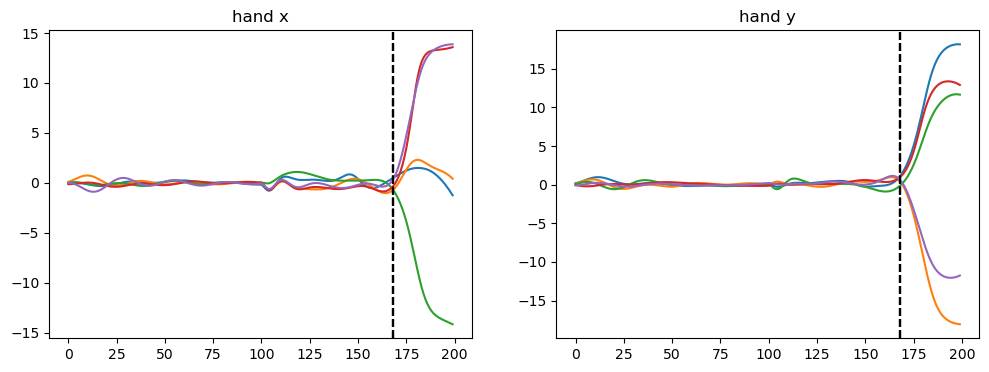

In [173]:
#plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in range(5):
    #plt.plot(nout[i,:,0])
    axs[0].plot(nout[i,:,0])
    axs[0].axvline(x=168, linestyle='--', color='k', linewidth=1.5)
    axs[0].set_title('hand x')

    axs[1].plot(nout[i,:,1])
    axs[1].axvline(x=168, linestyle='--', color='k', linewidth=1.5)
    axs[1].set_title('hand y')

In [10]:
# EXTRACT NETWORK WEIGHTS
params1=params.item()['params1']
# params1_o=paramso.item()['params1']
w_m2m=params1['whhl1'][:,:].T
from scipy.cluster.hierarchy import dendrogram, linkage
w_p2m=params1['wihl1'][:,:].T
w_out=params1['wout'][:,:].T
w_p2p=params1['whhl0'][:,:].T
w_u2p=params1['rnn0bto0'][:,:].T
w_in2p=params1['wihl0'][:,:].T

In [11]:
# CLUSTERIGN BASED ON M1 INTERNAL CONNECTIVITY AND PMD->M1 PROJECTION WEIGHTS
link=['ward','average','average','complete']
aff=['euclidean','cosine','cityblock','cosine']

link_m1='average'
aff_m1='cityblock'
link_pmd='ward'
aff_pmd='euclidean'

idx_m1=cluster(np.corrcoef(w_m2m.T),link=link_m1,aff=aff_m1)
bound_m1=GetBound(np.corrcoef(w_m2m.T),link=link_m1,aff=aff_m1,threshold=30.5).astype(int)
idx_pmd=cluster(w_p2m,link=link_pmd,aff=aff_pmd)
bound_pmd=GetBound(w_p2m,link=link_pmd,aff=aff_pmd,threshold=1.2).astype(int)
bound=np.array([0,bound_m1[0],sum(bound_m1[:2]),np.sum(bound_m1[:3]),400]).astype(int)
score=EvaluateCluster(np.corrcoef(w_m2m.T),bound,idx_m1)
print(score)
print(bound_m1)

67.12976239693297
[ 50 110 115 125]


In [ ]:
# (UNDER CONSTRUCTION) Calculate mean M1 cluster activity during movement 
dir=np.array(range(8))
sped=np.array([0,1,2,3,4])
d=np.array([0,2,4,6])

fig=PlotActivityHeatmap(m1_psth[sped][:,d,:,:][:,:,:,idx_m1a]) 


cmap = plt.cm.viridis  # Or any other colormap you prefer

# Create a scatter plot with colors based on z values
scatter = plt.scatter(x, y, c=z, cmap=cmap, norm=norm)

In [4]:
# PLOT M1 OUTPUT WEIGHTS
colors = ['red', 'blue', 'green', 'purple']
markers = ['o', 's', '^', 'x']
plt.figure(figsize=(6, 6))

bound_M1 = np.zeros(len(bound_m1)+1)
for i in range(len(bound_m1)+1):
        bound_M1[i] = np.sum(bound_m1[:i])
        if i==0 or i== len(bound_m1):
            continue
bound_M1 = bound_M1.astype(int)
print(bound_M1)

for i in range(len(bound_M1)-1):
    class_data = w_out[idx_m1[bound_M1[i]:bound_M1[i+1]]]
    plt.scatter(class_data[:, 0], class_data[:, 1], c=colors[i], marker=markers[i], label=f'Class {i+1}')

#plt.plot(np.linspace(-0.15,0.15,10),np.linspace(-0.15,0.15,10),'--',color='r')
plt.legend()
plt.title('connection weights from M1 to muscle')
plt.xlabel('w_x')
plt.ylabel('w_y')
#plt.savefig(savname+'M1output.png')
plt.show()

NameError: name 'bound_m1' is not defined

<Figure size 600x600 with 0 Axes>

In [ ]:
# plot PMd to M1 cluster weights next to its activity heatmap, sort by high overall weights, sort M1 activity by connectivity cluster



In [ ]:
# sort 

In [12]:
# CLUSTER BASED ON PMd or M1 activity
prw = np.arange(100, 198)
m1_acti=m1_nor_2[:,prw,:].reshape(-1,400).T
pmd_acti=pmd_nor_2[:,prw,:].reshape(-1,400).T
up_acti=up_nor_2[:,prw,:].reshape(-1,400).T
# 282-60到282+60对应手臂运动的time window (282 corresponds to GO signal)
link_m1a='average'
aff_m1a='cosine'
link_pmda='ward'
aff_pmda='euclidean'
vmin=None
vmax=None
idx_m1a=cluster(np.corrcoef(m1_acti),link=link_m1a,aff=aff_m1a)
bound_m1a=GetBound(np.corrcoef(m1_acti),link=link_m1a,aff=aff_m1a,threshold=0.5).astype(int)
idx_pmda=cluster(np.corrcoef(pmd_acti),link=link_pmda,aff=aff_pmda)
bound_pmda=GetBound(np.corrcoef(pmd_acti),link=link_pmda,aff=aff_pmda,threshold=50).astype(int)
m1_nor_2.shape

(200, 200, 400)

In [13]:
# CLUSTER BASED ON PMd or M1 movement activity
prw = np.arange(100, 168)
m1_acti=m1_nor_2[:,prw,:].reshape(-1,400).T
pmd_acti=pmd_nor_2[:,prw,:].reshape(-1,400).T
up_acti=up_nor_2[:,prw,:].reshape(-1,400).T
# 282-60到282+60对应手臂运动的time window (282 corresponds to GO signal)
link_m1a='average'
aff_m1a='cosine'
link_pmda='ward'
aff_pmda='euclidean'
vmin=None
vmax=None
idx_m1a=cluster(np.corrcoef(m1_acti),link=link_m1a,aff=aff_m1a)
bound_m1a=GetBound(np.corrcoef(m1_acti),link=link_m1a,aff=aff_m1a,threshold=0.5).astype(int)
idx_pmda=cluster(np.corrcoef(pmd_acti),link=link_pmda,aff=aff_pmda)
bound_pmda=GetBound(np.corrcoef(pmd_acti),link=link_pmda,aff=aff_pmda,threshold=50).astype(int)
#idx_upa=cluster(np.corrcoef(up_acti),link=link_upa,aff=aff_upa)
#bound_upa=GetBound(np.corrcoef(up_acti),link=link_upa,aff=aff_upa,threshold=50).astype(int)

bound_M1a=np.array([0,np.sum(bound_m1[:1]),np.sum(bound_m1[:2])\
                    ,np.sum(bound_m1[:3]),np.sum(bound_m1[:4]),400]).astype(int)
bound_PMda=np.array([0,np.sum(bound_pmd[:1]),np.sum(bound_pmd[:2])\
                    ,np.sum(bound_pmd[:3]),np.sum(bound_pmd[:4]),400]).astype(int)
#bound_UPa=np.array([0,np.sum(bound_up[:1]),np.sum(bound_up[:2])\
#                    ,np.sum(bound_up[:3]),np.sum(bound_up[:4]),400]).astype(int)
# bound_M1a
bound_PMda

array([  0,  46, 183, 249, 299, 400])

In [ ]:
# plot PMd mean pre-MO*PMd->M1 weights activity as matrix
dir=np.array(range(8))
sped=np.array([0,1,2,3,4])
d=np.array([0,2,4,6])
d = 0
idx = idx_pmda
matrix = pmd_psth[sped][:,d,:,:][:,:,:,idx]
n=np.nanmean(matrix[:,idx[bound[0]:bound[1]]],axis=0)

ax_list=np.linspace(0,399,21,dtype=int)
ax_list=list(ax_list)
# speed_num=len(speed)
# dir_num=len(dir)
fig=plt.figure(figsize=(20, 20))
subplotspec = axs.get_subplotspec()
gs00 = GridSpecFromSubplotSpec(dir_num,1, subplot_spec=subplotspec, wspace=0.1, hspace=0.1)
# for j in range(dir_num):#dir cond 
j = 0;
    ax1 = fig.add_subplot(gs00[j,0]) 
    ax1=sns.heatmap(matrix[i,j].T,ax=ax1,cmap='jet',cbar=False)
    ax1.text(0.5, 1.01,f'dir={dir[j]*45}°', fontsize=13,horizontalalignment='center',\
                  verticalalignment='bottom', transform=plt.gca().transAxes)
    ax1.set_yticks(ax_list,idx[ax_list])
    ax1.set_xticks([0,67],['TO','MO'],rotation=0)


j = 0;
    ax1 = fig.add_subplot(gs00[j,0]) 
    ax1=sns.heatmap(matrix[i,j].T,ax=ax1,cmap='jet',cbar=False)
    ax1.text(0.5, 1.01,f'dir={dir[j]*45}°', fontsize=13,horizontalalignment='center',\
                  verticalalignment='bottom', transform=plt.gca().transAxes)
    ax1.set_yticks(ax_list,idx[ax_list])
    ax1.set_xticks([0,67],['TO','MO'],rotation=0)

            
for k in range(len(bound)):
    ax1.axhline(bound[k],linestyle='--',color='white')
    ax1.axvline(x=67, linestyle='--', color='w', linewidth=1.5)
    ax1.invert_yaxis()    


for i in range(len(bound)-1):
    n=np.nanmean(activity[:,idx[bound[i]:bound[i+1]]],axis=0)
    colors=cmap((n+abs(np.min(n)))*(1/np.max(n+abs(np.min(n)))))

(2,)

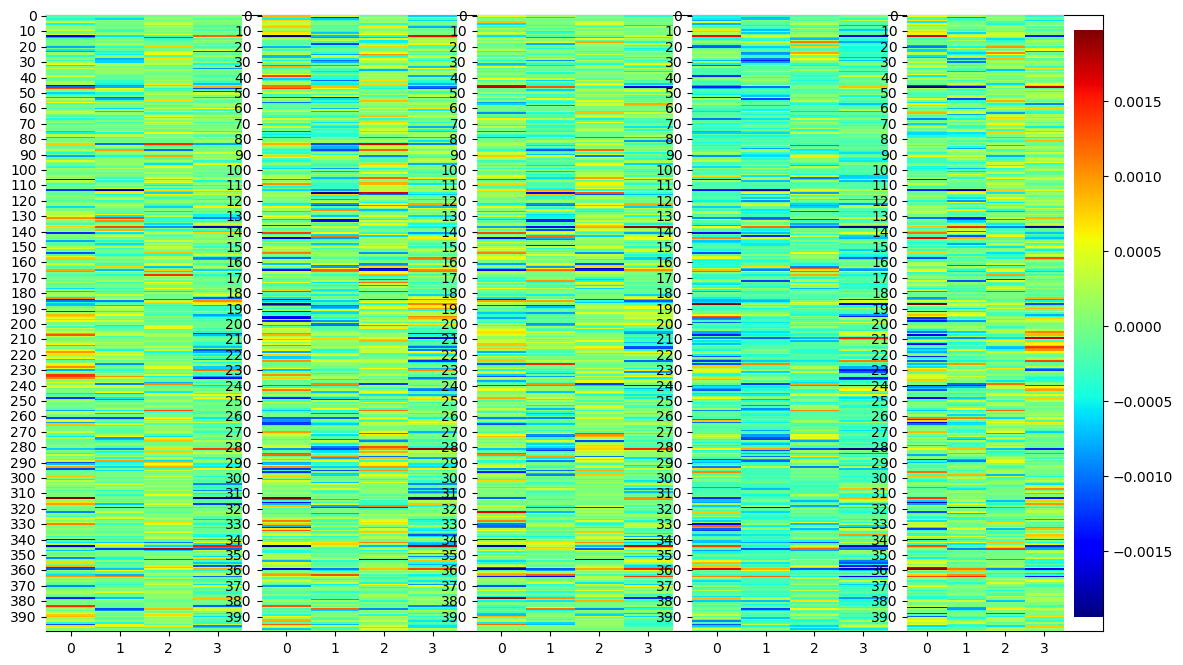

In [143]:
dir=np.array(range(8))
sped=np.array([0,1,2,3,4]) # [0,1,2,3,4]
d=np.array([0,2,4,6]) # [0,2,4,6]
ax_list=np.linspace(0,399,21,dtype=int)
ax_list=list(ax_list)
binr = np.array([65,70])

# get neural activity of all PMd neurons sorted by activity cluster
matrix = pmd_psth[sped][:,d,:,:][:,:,:,idx_pmd]
# calculate pmd activity right before MO
pmda_mo = np.nanmean(matrix[:,:,binr[0]:binr[1]],axis=2)
# pmdamo = np.reshape(pmda_mo[i,j], (1,400))

fig=plt.figure(figsize=(30, 8))
axs=plt.subplot(1,2,1)
axs.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
axs.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
axs.set_xticks([])  # 移除x轴的刻度标记
axs.set_yticks([])

subplotspec = axs.get_subplotspec()
gs00 = GridSpecFromSubplotSpec(1,5, subplot_spec=subplotspec, wspace=0.1, hspace=0.1)
# for j in range(dir_num):#dir cond 
i = 0 # speed id
j = 0 # direction id
# ax1 = fig.add_subplot(gs00[0,0]) 
# ax1=sns.heatmap(matrix[i,j].T,ax=ax1,cmap='jet',cbar=False)
# ax1.text(0.5, 1.01,f'dir={d[j]*45}° spd={speed_cond[sped[i]]}°/s', fontsize=13,horizontalalignment='center',\
#                   verticalalignment='bottom', transform=plt.gca().transAxes)
# ax1.set_yticks(ax_list,idx_pmda[ax_list])
# ax1.set_xticks([0,67],['TO','MO'],rotation=0)
# ax1.invert_yaxis()
# ax1.axvline(x=67, linestyle='--', color='w', linewidth=1.5)
# for k in range(len(bound_PMda)):
#         ax1.axhline(bound_PMda[k],linestyle='--',color='white')

# multiple pmd pre-MO activity by its average output weights to each M1 cluster
pmdamo = np.reshape(pmda_mo[i,j], (1,400))
wp2m_mean = np.zeros((400,len(bound_M1)-1))
pmdout = np.zeros_like(wp2m_mean)
for ii in range(len(bound_M1)-1):
    wp2m_mean[:,ii] = np.nanmean(w_p2m[idx_pmd][:,idx_m1[bound[ii]:bound[ii+1]]],axis = 1)
    pmdout[:,ii] = pmdamo*wp2m_mean[:,ii]


ax1 = fig.add_subplot(gs00[0,0]) 
ax1=sns.heatmap(pmdout,ax=ax1,cmap='jet',cbar=False)

i = 1 # speed id
j = 0 # direction id
# ax1 = fig.add_subplot(gs00[0,0+1]) 
# ax1=sns.heatmap(matrix[i,j].T,ax=ax1,cmap='jet',cbar=False)
# ax1.text(0.5, 1.01,f'dir={d[j]*45}° spd={speed_cond[sped[i]]}°/s', fontsize=13,horizontalalignment='center',\
#                   verticalalignment='bottom', transform=plt.gca().transAxes)
# ax1.set_yticks(ax_list,idx_pmda[ax_list])
# ax1.set_xticks([0,67],['TO','MO'],rotation=0)
# ax1.invert_yaxis()
# ax1.axvline(x=67, linestyle='--', color='w', linewidth=1.5)
# for k in range(len(bound_PMda)):
#         ax1.axhline(bound_PMda[k],linestyle='--',color='white')

# multiple pmd pre-MO activity by its average output weights to each M1 cluster
pmdamo = np.reshape(pmda_mo[i,j], (1,400))
wp2m_mean = np.zeros((400,len(bound_M1)-1))
pmdout = np.zeros_like(wp2m_mean)
for ii in range(len(bound_M1)-1):
    wp2m_mean[:,ii] = np.nanmean(w_p2m[idx_pmd][:,idx_m1[bound[ii]:bound[ii+1]]],axis = 1)
    pmdout[:,ii] = pmdamo*wp2m_mean[:,ii]

ax3 = fig.add_subplot(gs00[0,1]) 
ax3=sns.heatmap(pmdout,ax=ax3,cmap='jet',cbar=False)



i = 2 # speed id
j = 0 # direction id
# ax1 = fig.add_subplot(gs00[0,0+2]) 
# ax1=sns.heatmap(matrix[i,j].T,ax=ax1,cmap='jet',cbar=False)
# ax1.text(0.5, 1.01,f'dir={d[j]*45}° spd={speed_cond[sped[i]]}°/s', fontsize=13,horizontalalignment='center',\
#                   verticalalignment='bottom', transform=plt.gca().transAxes)
# ax1.set_yticks(ax_list,idx_pmda[ax_list])
# ax1.set_xticks([0,67],['TO','MO'],rotation=0)
# ax1.invert_yaxis()
# ax1.axvline(x=67, linestyle='--', color='w', linewidth=1.5)
# for k in range(len(bound_PMda)):
#         ax1.axhline(bound_PMda[k],linestyle='--',color='white')

# multiply pmd pre-MO activity by its average output weights to each M1 cluster
pmdamo = np.reshape(pmda_mo[i,j], (1,400))
wp2m_mean = np.zeros((400,len(bound_M1)-1))
pmdout = np.zeros_like(wp2m_mean)
for ii in range(len(bound_M1)-1):
    wp2m_mean[:,ii] = np.nanmean(w_p2m[idx_pmd][:,idx_m1[bound[ii]:bound[ii+1]]],axis = 1)
    pmdout[:,ii] = pmdamo*wp2m_mean[:,ii]

ax3 = fig.add_subplot(gs00[0,2]) 
ax3=sns.heatmap(pmdout,ax=ax3,cmap='jet',cbar=False)


i = 3 # speed id
j = 0 # direction id
# ax1 = fig.add_subplot(gs00[0,0+3]) 
# ax1=sns.heatmap(matrix[i,j].T,ax=ax1,cmap='jet',cbar=False)
# ax1.text(0.5, 1.01,f'dir={d[j]*45}° spd={speed_cond[sped[i]]}°/s', fontsize=13,horizontalalignment='center',\
#                   verticalalignment='bottom', transform=plt.gca().transAxes)
# ax1.set_yticks(ax_list,idx_pmda[ax_list])
# ax1.set_xticks([0,67],['TO','MO'],rotation=0)
# ax1.invert_yaxis()
# ax1.axvline(x=67, linestyle='--', color='w', linewidth=1.5)
# for k in range(len(bound_PMda)):
#         ax1.axhline(bound_PMda[k],linestyle='--',color='white')

# multiple pmd pre-MO activity by its average output weights to each M1 cluster
pmdamo = np.reshape(pmda_mo[i,j], (1,400))
wp2m_mean = np.zeros((400,len(bound_M1)-1))
pmdout = np.zeros_like(wp2m_mean)
for ii in range(len(bound_M1)-1):
    wp2m_mean[:,ii] = np.nanmean(w_p2m[idx_pmd][:,idx_m1[bound[ii]:bound[ii+1]]],axis = 1)
    pmdout[:,ii] = pmdamo*wp2m_mean[:,ii]

ax3 = fig.add_subplot(gs00[0,3]) 
ax3=sns.heatmap(pmdout,ax=ax3,cmap='jet',cbar=False)


i = 4 # speed id
j = 0 # direction id
# ax1 = fig.add_subplot(gs00[0,0+4]) 
# ax1=sns.heatmap(matrix[i,j].T,ax=ax1,cmap='jet',cbar=False)
# ax1.text(0.5, 1.01,f'dir={d[j]*45}° spd={speed_cond[sped[i]]}°/s', fontsize=13,horizontalalignment='center',\
#                   verticalalignment='bottom', transform=plt.gca().transAxes)
# ax1.set_yticks(ax_list,idx_pmda[ax_list])
# ax1.set_xticks([0,67],['TO','MO'],rotation=0)
# ax1.invert_yaxis()
# ax1.axvline(x=67, linestyle='--', color='w', linewidth=1.5)
# for k in range(len(bound_PMda)):
#         ax1.axhline(bound_PMda[k],linestyle='--',color='white')

# multiple pmd pre-MO activity by its average output weights to each M1 cluster
pmdamo = np.reshape(pmda_mo[i,j], (1,400))
wp2m_mean = np.zeros((400,len(bound_M1)-1))
pmdout = np.zeros_like(wp2m_mean)
for ii in range(len(bound_M1)-1):
    wp2m_mean[:,ii] = np.nanmean(w_p2m[idx_pmd][:,idx_m1[bound[ii]:bound[ii+1]]],axis = 1)
    pmdout[:,ii] = pmdamo*wp2m_mean[:,ii]

ax3 = fig.add_subplot(gs00[0,4]) 
ax3=sns.heatmap(pmdout,ax=ax3,cmap='jet',cbar=True)

binr.shape

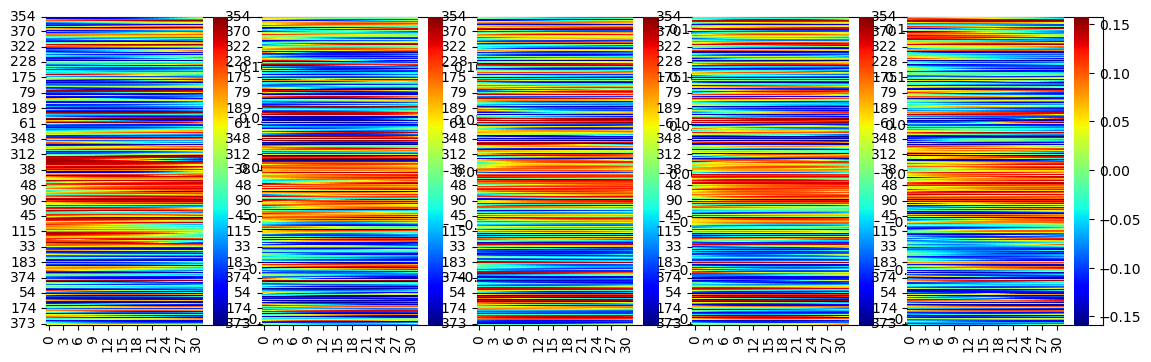

In [150]:
# plot full PMd output matrix
fig=plt.figure(figsize=(30, 4))
axs=plt.subplot(1,2,1)
axs.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
axs.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
axs.set_xticks([])  # 移除x轴的刻度标记
axs.set_yticks([])

subplotspec = axs.get_subplotspec()
gs00 = GridSpecFromSubplotSpec(1,5, subplot_spec=subplotspec, wspace=0.1, hspace=0.1)

i = 0 # speed id
j = 1 # direction id


for i in range(5):
# multiply pmd pre-MO activity by its output weights to each M1 cluster
    pmdamo = np.reshape(pmda_mo[i,j], (1,400))
    # wp2m_mean = np.zeros((400,len(bound_M1)-1))
    wp2m_c = w_p2m[idx_pmd][:,idx_m1]
    pmdoutf = np.zeros_like(w_p2m)
    # for ii in range(len(bound_M1)-1):
    #     wp2m_mean[:,ii] = np.nanmean(w_p2m[idx_pmd][:,idx_m1[bound[ii]:bound[ii+1]]],axis = 1)
    pmdoutf = pmdamo #*w_p2m.T
    # pmdf = (matrix[i,j,40:68,ax_list])
    # pmdf = np.reshape(pmdoutf,(28,400))

    ax1 = fig.add_subplot(gs00[0,i]) 
    ax1=sns.heatmap(matrix[i,j,68:100].T,ax=ax1,cmap='jet',cbar=True)
    ax1.set_yticks(ax_list,idx_pmd[ax_list])


In [142]:
dmat = matrix[:,:,binr[0]:binr[1]]

AttributeError: 'list' object has no attribute 'len'

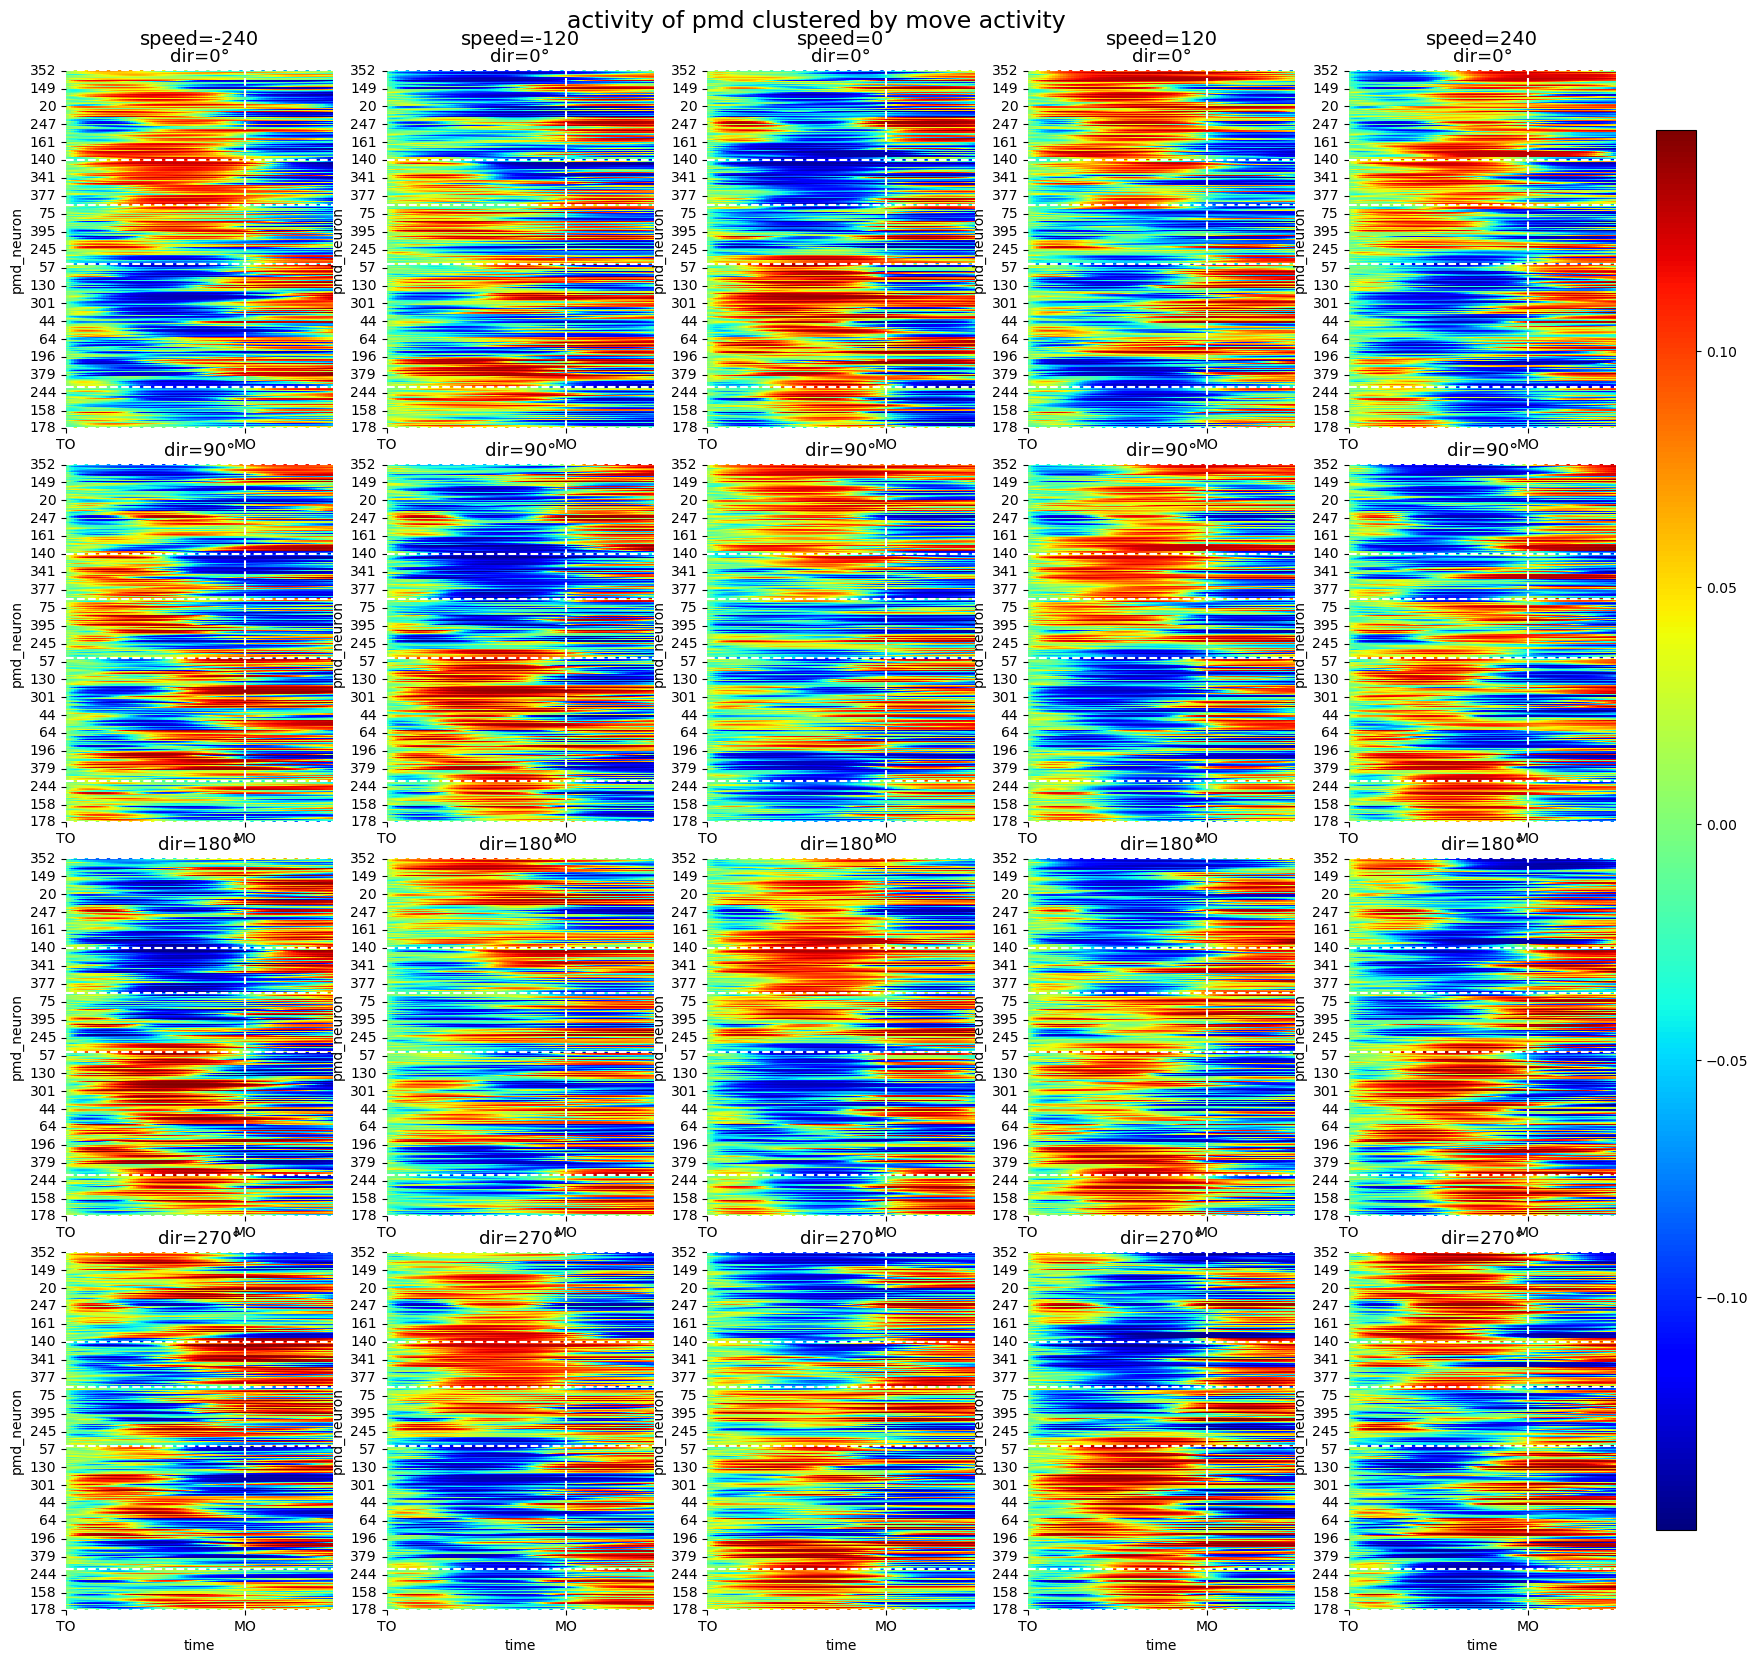

In [48]:
# plot PMd activity based on weight or activity clustering
ax_list=np.linspace(0,399,21,dtype=int)
ax_list=list(ax_list)
dir=np.array(range(8))
sped=np.array([0,1,2,3,4])
d=np.array([0,2,4,6])
#fig=PlotActivityHeatmap(pmd_psth[sped][:,:4,:,idx_pmd],'pmd',speed_cond[sped],dir[d],-0.1,0.1,bound,idx_pmd) 
#plt.suptitle('activity of pmd clusters under different condition',y=0.91,fontsize=17)
#plt.savefig('PMda_sortbywclust.png')

fig=PlotActivityHeatmap(pmd_psth[sped][:,d,:,:][:,:,:,idx_pmda],'pmd',speed_cond[sped],dir[d],-0.1,0.1,bound_PMda,idx_pmda) 
plt.suptitle('activity of pmd clustered by move activity',y=0.91,fontsize=17)
plt.savefig('PMda_sortbyprpact2.png')

In [ ]:
# plot PMd mean pre-MO activity*PMd->M1 weights as matrix
cmap = plt.get_cmap('jet') 
for j in range(8):
    fig=am.PlotOutput(w_out,idx_m1,bound_M1,cmap,markers,activity=m1_psth[0,j,68:])
    #plt.savefig(savname+f'M1output_{j}.png')
    plt.show()


fig=plt.figure(figsize=(6, 6))
    plt.rcParams.update({'font.size': 18})  
    cmap = plt.get_cmap('jet') 
    ax=plt.subplot(1,1,1)
    if activity.size==0:
        for i in range(len(bound)-1):
            class_data = matrix[idx[bound[i]:bound[i+1]]]
            plt.scatter(class_data[:, 0], class_data[:, 1], c=colors[i], marker=markers[i], label=f'Cluster {i+1}')
    else:
        for i in range(len(bound)-1):
            n=np.nanmean(activity[:,idx[bound[i]:bound[i+1]]],axis=0)
            colors=cmap((n+abs(np.min(n)))*(1/np.max(n+abs(np.min(n)))))
            class_data = matrix[idx[bound[i]:bound[i+1]]]
            sc=ax.scatter(class_data[:, 0], class_data[:, 1], c=colors, marker=markers[i], label=f'Cluster {i+1}')
        
    plt.legend(bbox_to_anchor=(1.05, 0.25), loc=3, borderaxespad=0)
    plt.grid(False)
    plt.axhline(y=0,color='gray',linestyle=':')
    plt.axvline(x=0,color='gray',linestyle=':')
    plt.xlabel('w_x')
    plt.ylabel('w_y')

([<matplotlib.axis.XTick at 0x1a72f904e90>,
 [Text(0, 0, '112'),
  Text(19, 0, '111'),
  Text(39, 0, '159'),
  Text(59, 0, '287'),
  Text(79, 0, '78'),
  Text(99, 0, '5'),
  Text(119, 0, '37'),
  Text(139, 0, '163'),
  Text(159, 0, '396'),
  Text(179, 0, '347'),
  Text(199, 0, '280'),
  Text(219, 0, '31'),
  Text(239, 0, '34'),
  Text(259, 0, '232'),
  Text(279, 0, '241'),
  Text(299, 0, '247'),
  Text(319, 0, '249'),
  Text(339, 0, '145'),
  Text(359, 0, '319'),
  Text(379, 0, '371'),
  Text(399, 0, '399')])

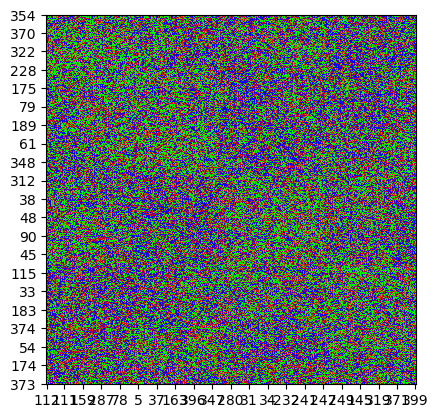

In [131]:
# plot clustering result:
#idx_pmd=np.array(idx_pmd)
#idx=np.array(idx)
X_sort=(w_p2m)[idx_pmda][:,idx_m1a]
#X_sort=(np.corrcoef(w_p2m.T))[idx][:,idx]

ax_list=np.linspace(0,399,21,dtype=int)
ax_list=list(ax_list)

plt.imshow(X_sort, cmap='brg', vmin = -.03, vmax=.03,interpolation='nearest') 
plt.yticks(ax_list,idx_pmd[ax_list])
plt.xticks(ax_list,idx_m1[ax_list])

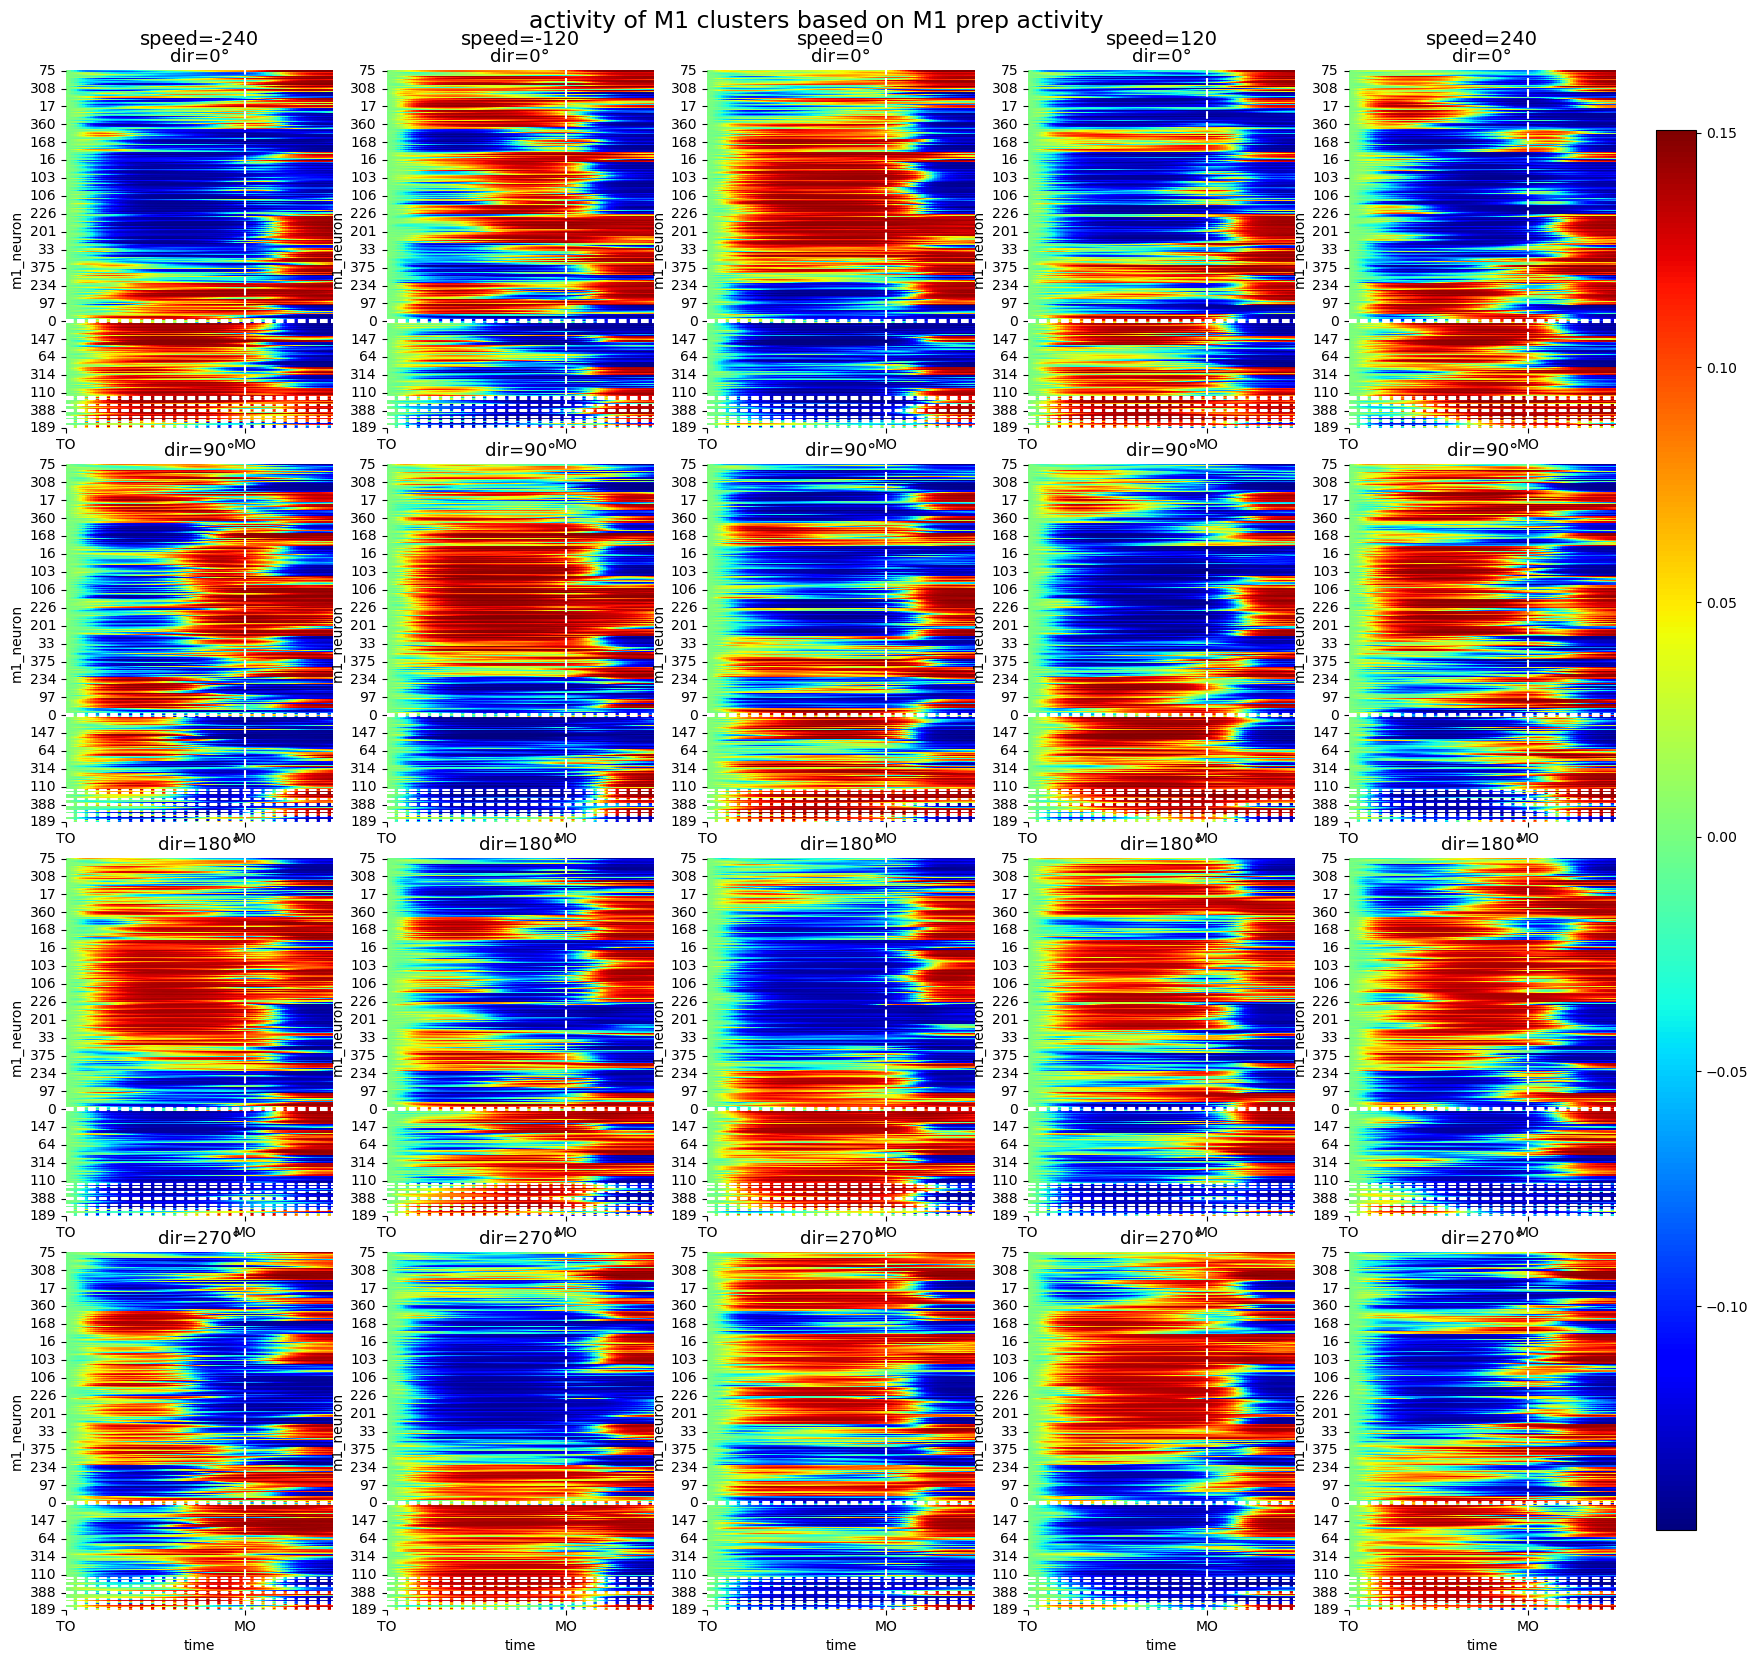

In [121]:
# plot M1 activity based on weight or activity clustering
dir=np.array(range(8))
sped=np.array([0,1,2,3,4])
d=np.array([0,2,4,6])

fig=PlotActivityHeatmap(m1_psth[sped][:,d,:,:][:,:,:,idx_m1a],'m1',speed_cond[sped],dir[d],-0.1,0.1,bound_M1a,idx_m1a) 
plt.suptitle('activity of M1 clusters based on M1 prep activity',y=0.91,fontsize=17)
plt.savefig('M1a_sortbymov_prpact.png')

In [ ]:
# PLOT M1 activity as heatmap
bound_M1=np.array([0,50,160,275,400])
bound_PMd=np.array([0,np.sum(bound_pmd[:1]),np.sum(bound_pmd[:2])\
                    ,np.sum(bound_pmd[:3]),np.sum(bound_pmd[:4]),400]).astype(int)

dir=np.array(range(8))
bound=np.array([50,160,275])
sped=np.array([0,1,2,4])
d=np.array([0,2,4,6])
fig=PlotActivityHeatmap(m1_psth[sped][:,d,:,:][:,:,:,idx_m1],'M1',speed_cond[sped],dir[d],-0.1,0.1,bound_M1[1:-1],idx_m1) 
plt.suptitle('activity of M1 clusters under different condition',y=0.91,fontsize=17)
#plt.savefig(savname+'activity of M1 cluster_1.png')
fig=PlotActivityHeatmap(pmd_psth[sped][:,d,:,:][:,:,:,idx_pmd],'PMd',speed_cond[sped],dir[d],-0.1,0.1,bound_PMd[1:-1],idx_m1) 
plt.suptitle('activity of PMd clusters under different condition',y=0.91,fontsize=17)
#plt.savefig(savname+'activity of PMd cluster_1.png')
fig=PlotActivityHeatmap(m1_psth[sped][:,d,:,:][:,:,:,idx_m1a],'M1',speed_cond[sped],dir[d],-0.1,0.1,bound_M1a[1:-1],idx_m1a) 
plt.suptitle('activity of M1 clusters(activity) under different condition',y=0.91,fontsize=17)
#plt.savefig(savname+'activity of M1 cluster_2.png')
fig=PlotActivityHeatmap(pmd_psth[sped][:,d,:,:][:,:,:,idx_pmda],'PMd',speed_cond[sped],dir[d],-0.1,0.1,bound_PMda[1:-1],idx_pmda) 
plt.suptitle('activity of PMd clusters(activity) under different condition',y=0.91,fontsize=17)
#plt.savefig(savname+'activity of PMd cluster_2.png')
# fig=PlotActivityHeatmap(m1_psth[sped][:,4:,:,idx_m1],'M1',speed_cond[sped],dir[4:],-0.1,0.1,bound,idx_m1) 
# plt.suptitle('activity of M1 clusters under different condition',y=0.91,fontsize=17)
# plt.savefig(savname+'activity of M1 cluster_2.png')
